# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [46]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# from pyfinance.ols import PandasRollingOLS
# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load US equity OHLCV data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [49]:
DATA_STORE = '../data/assets.h5'

In [50]:
YEAR = 12

In [51]:
START = 2006
END = 2018

In [52]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], :]
              .filter(like='adj_')
              .dropna()
              .swaplevel()
              .rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['us_equities/stocks']
                    .loc[:, ['sector']])
              .dropna())

In [53]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6482328 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2018-03-27 00:00:00'))
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
 5   sector  object 
dtypes: float64(5), object(1)
memory usage: 322.2+ MB


In [54]:
len(prices.index.unique('ticker'))
print (prices)

                        open       high        low      close        volume  \
ticker date                                                                   
A      2006-01-03  22.786839  22.909642  22.387796  22.855063  3.796200e+06   
AAL    2006-01-03  96.658326  99.464536  95.748907  97.307912  1.013200e+06   
AAN    2006-01-03  12.368407  12.690501  12.368407  12.690501  3.100500e+03   
AAON   2006-01-03   3.077759   3.111957   3.019624   3.110247  2.760075e+04   
AAP    2006-01-03  41.504375  41.867192  41.342062  41.552114  1.613400e+06   
...                      ...        ...        ...        ...           ...   
ZIXI   2018-03-27   4.430000   4.450000   4.350000   4.390000  2.073040e+05   
ZNGA   2018-03-27   3.850000   3.850000   3.680000   3.700000  1.102601e+07   
ZOES   2018-03-27  15.130000  15.240000  14.750000  14.880000  2.612420e+05   
ZTS    2018-03-27  84.080000  84.450000  81.210000  81.860000  2.676191e+06   
ZUMZ   2018-03-27  24.650000  24.650000  23.350000  

## Remove stocks with less than ten years of data

In [55]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')

In [56]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5770939 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2018-03-27 00:00:00'))
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
 5   sector  object 
dtypes: float64(5), object(1)
memory usage: 287.0+ MB


In [57]:
len(prices.index.unique('ticker'))

1893

## Add some Basic Factors

### Compute the Relative Strength Index

In [58]:
prices['rsi'] = prices.groupby(level='ticker').close.transform(RSI)
# Display the DataFrame with the new RSI column
print(prices)



                        open       high        low      close       volume  \
ticker date                                                                  
A      2006-01-03  22.786839  22.909642  22.387796  22.855063  3796200.000   
AAL    2006-01-03  96.658326  99.464536  95.748907  97.307912  1013200.042   
AAN    2006-01-03  12.368407  12.690501  12.368407  12.690501     3100.500   
AAON   2006-01-03   3.077759   3.111957   3.019624   3.110247    27600.750   
AAP    2006-01-03  41.504375  41.867192  41.342062  41.552114  1613400.000   
...                      ...        ...        ...        ...          ...   
ZEUS   2018-03-27  20.530000  20.770000  20.140000  20.250000    97615.000   
ZION   2018-03-27  53.250000  53.710000  51.620000  52.020000  2214940.000   
ZIOP   2018-03-27   4.270000   4.270000   4.050000   4.050000   983328.000   
ZIXI   2018-03-27   4.430000   4.450000   4.350000   4.390000   207304.000   
ZUMZ   2018-03-27  24.650000  24.650000  23.350000  23.600000   

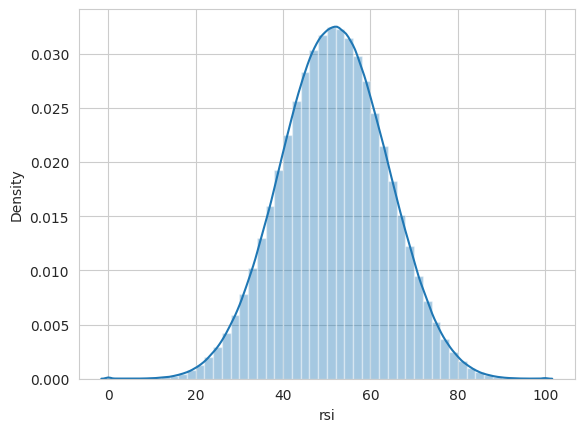

In [59]:
sns.distplot(prices.rsi);

### Compute Bollinger Bands

In [60]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [61]:
prices_test = prices.groupby(level=0).close.apply(compute_bb)

prices_dropped_level = prices_test.droplevel(level=1)

print(prices_dropped_level)

prices = prices.join(prices_dropped_level)



                    bb_high    bb_mid    bb_low
ticker date                                    
A      2006-01-03       NaN       NaN       NaN
       2006-01-04       NaN       NaN       NaN
       2006-01-05       NaN       NaN       NaN
       2006-01-06       NaN       NaN       NaN
       2006-01-09       NaN       NaN       NaN
...                     ...       ...       ...
ZUMZ   2018-03-21  3.197431  3.075158  2.952884
       2018-03-22  3.213935  3.083037  2.952138
       2018-03-23  3.230087  3.090254  2.950422
       2018-03-26  3.253662  3.098963  2.944263
       2018-03-27  3.265419  3.107352  2.949286

[5770939 rows x 3 columns]


In [62]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5770939 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2018-03-27 00:00:00'))
Data columns (total 10 columns):
 #   Column   Dtype  
---  ------   -----  
 0   open     float64
 1   high     float64
 2   low      float64
 3   close    float64
 4   volume   float64
 5   sector   object 
 6   rsi      float64
 7   bb_high  float64
 8   bb_mid   float64
 9   bb_low   float64
dtypes: float64(9), object(1)
memory usage: 592.1+ MB


In [63]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,5.734972e+06,5.734972e+06,5.734972e+06
mean,3.219076e+00,3.147699e+00,3.076321e+00
std,9.491458e-01,9.585576e-01,9.715639e-01
min,9.950331e-03,9.950331e-03,-1.568426e+00
25%,2.636384e+00,2.557725e+00,2.477769e+00
50%,3.227299e+00,3.158179e+00,3.090612e+00
75%,3.792965e+00,3.730686e+00,3.670796e+00
max,1.285556e+01,1.277805e+01,1.274063e+01


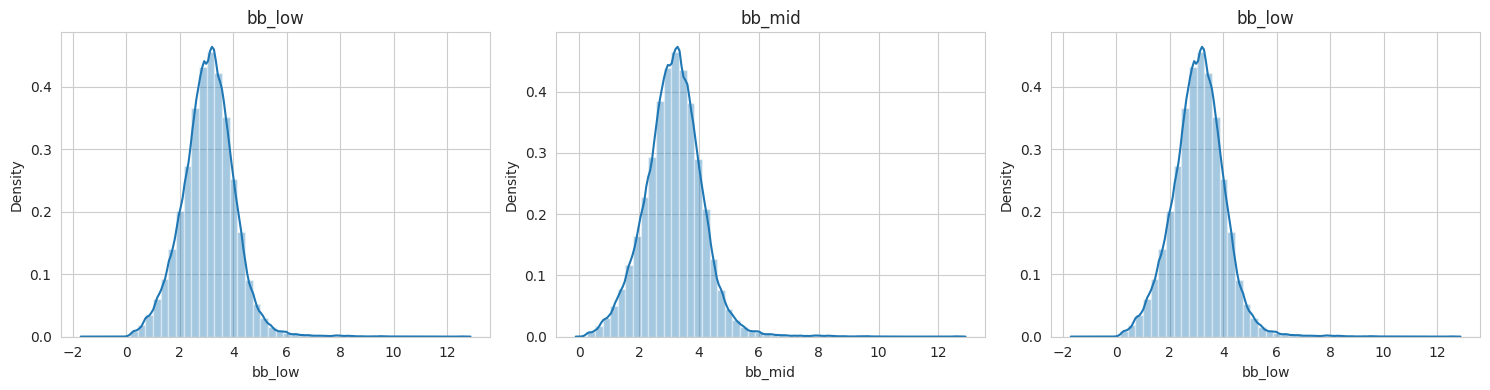

In [64]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [65]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)

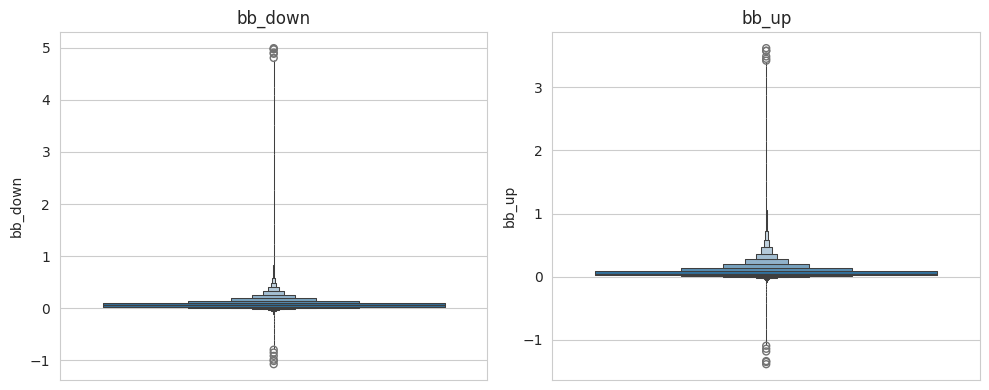

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

### Compute Average True Range

Helper for indicators with multiple inputs:

In [67]:
by_ticker = prices.groupby('ticker', group_keys=False)

In [68]:
def compute_atr(stock_data):
    atr = ATR(stock_data.high, 
              stock_data.low, 
              stock_data.close, 
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

In [69]:
prices['atr'] = by_ticker.apply(compute_atr)

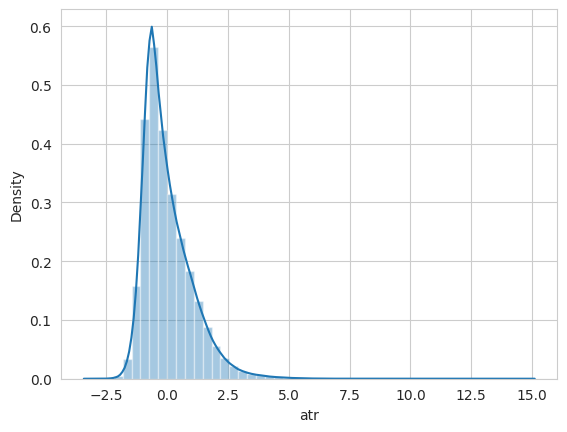

In [70]:
sns.distplot(prices.atr);

In [71]:
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))

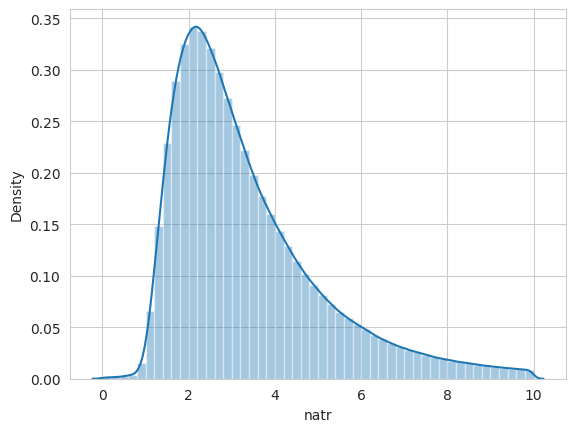

In [72]:
sns.distplot(prices.natr[prices.natr<10]);

### Compute Moving Average Convergence/Divergence

In [73]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.transform(compute_macd)

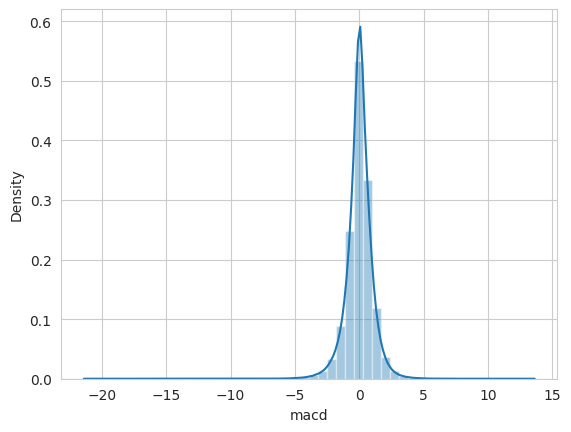

In [74]:
sns.distplot(prices.macd);

## Compute dollar volume to determine universe

In [75]:
prices['dollar_volume'] = (prices.loc[:, 'close']
                           .mul(prices.loc[:, 'volume'], axis=0))

prices.dollar_volume /= 1e6

In [76]:
prices.to_hdf('data.h5', 'us/equities/prices')

In [77]:
prices = pd.read_hdf('data.h5', 'us/equities/prices')
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5770939 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2018-03-27 00:00:00'))
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   open           float64
 1   high           float64
 2   low            float64
 3   close          float64
 4   volume         float64
 5   sector         object 
 6   rsi            float64
 7   bb_high        float64
 8   bb_mid         float64
 9   bb_low         float64
 10  bb_up          float64
 11  bb_down        float64
 12  atr            float64
 13  natr           float64
 14  macd           float64
 15  dollar_volume  float64
dtypes: float64(15), object(1)
memory usage: 727.2+ MB


## Resample OHLCV prices to monthly frequency

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [78]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                              'open', 'high', 'low']]

In [79]:
prices = prices.unstack('ticker')

In [80]:
data = (pd.concat([prices.dollar_volume.resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')],
                  axis=1)
        .swaplevel()
        .dropna())

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 273742 entries, ('A', Timestamp('2006-02-28 00:00:00')) to ('IRDM', Timestamp('2018-03-31 00:00:00'))
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   dollar_volume  273742 non-null  float64
 1   close          273742 non-null  float64
 2   sector         273742 non-null  object 
 3   rsi            273742 non-null  float64
 4   bb_high        273742 non-null  float64
 5   bb_mid         273742 non-null  float64
 6   bb_low         273742 non-null  float64
 7   bb_up          273742 non-null  float64
 8   bb_down        273742 non-null  float64
 9   atr            273742 non-null  float64
 10  natr           273742 non-null  float64
 11  macd           273742 non-null  float64
dtypes: float64(11), object(1)
memory usage: 26.2+ MB


## Select 500 most-traded equities

Select the 500 most-traded stocks based on a 5-year rolling average of dollar volume.

In [82]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume']
                         .unstack('ticker')
                         .rolling(window=5*12, min_periods=12)
                         .mean()
                         .stack()
                         .swaplevel())

In [83]:
data['dollar_vol_rank'] = (data
                           .groupby('date')
                           .dollar_volume
                           .rank(ascending=False))

data = data[data.dollar_vol_rank < 500].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

In [84]:
len(data.index.unique('ticker'))

650

## Create monthly return series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [85]:
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []

In [86]:
returns_list = []
for lag in lags:
    return_series = (data
                     .close
                     .unstack('ticker')
                     .sort_index()
                     .pct_change(lag)
                     .stack('ticker')
                     .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                            upper=x.quantile(1-outlier_cutoff)))
                     .add(1)
                     .pow(1/lag)
                     .sub(1)
                     .to_frame(f'return_{lag}m')
                     )
    returns_list.append(return_series)

# Concatenate all the return series along the columns axis
returns = pd.concat(returns_list, axis=1).swaplevel()
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 78605 entries, ('A', Timestamp('2007-02-28 00:00:00')) to ('SCG', Timestamp('2018-03-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   78605 non-null  float64
 1   return_3m   77305 non-null  float64
 2   return_6m   75361 non-null  float64
 3   return_12m  71506 non-null  float64
dtypes: float64(4)
memory usage: 2.7+ MB


In [87]:






returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,78605.000000,77305.000000,75361.000000,71506.000000
mean,0.006989,0.004939,0.004112,0.003714
std,0.086479,0.053110,0.040128,0.029003
min,-0.270265,-0.188189,-0.147799,-0.103216
25%,-0.030165,-0.014554,-0.009230,-0.005577
50%,0.000000,0.000738,0.002593,0.003665
75%,0.048683,0.032581,0.025145,0.019366
max,0.289220,0.161772,0.114636,0.084997


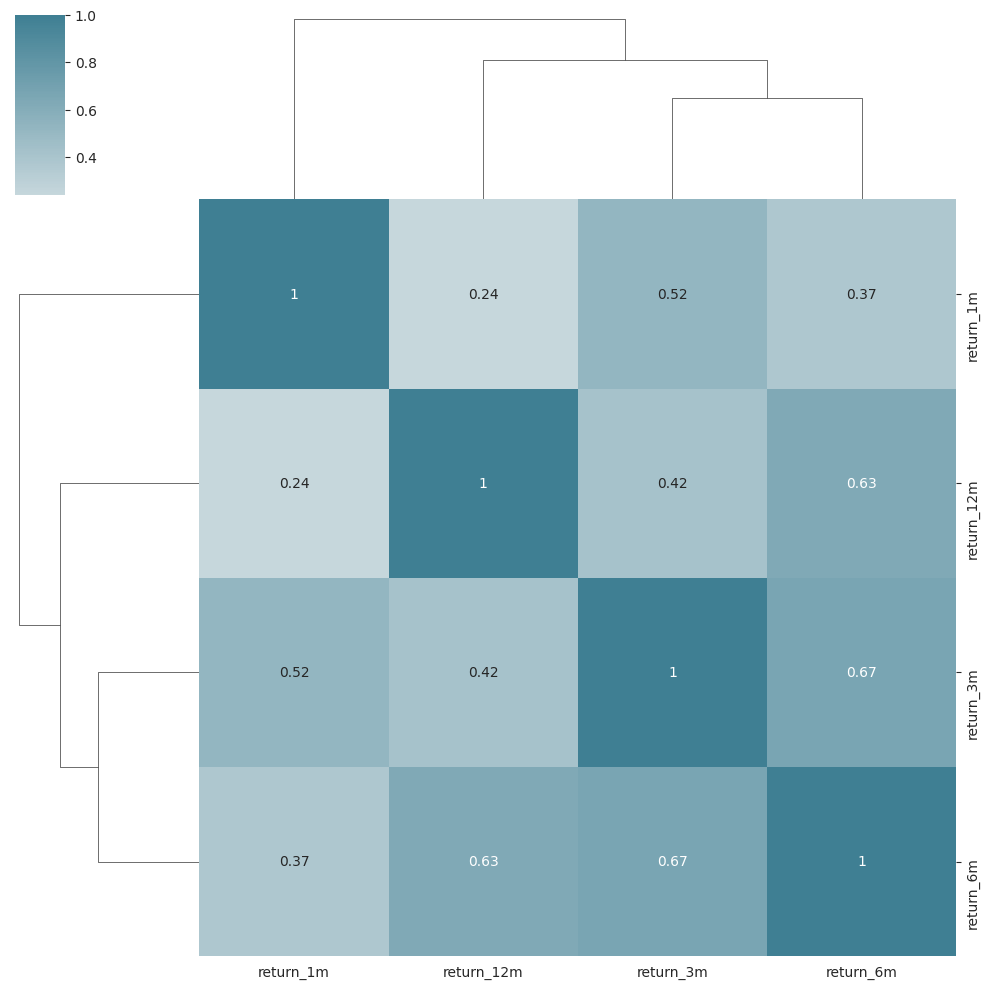

In [88]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [89]:
#data = data.join(returns).drop('close', axis=1).dropna()
data = pd.concat([data, returns], axis=1).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 59863 entries, ('A', Timestamp('2008-01-31 00:00:00')) to ('V', Timestamp('2018-03-31 00:00:00'))
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   close       59863 non-null  float64
 1   sector      59863 non-null  object 
 2   rsi         59863 non-null  float64
 3   bb_high     59863 non-null  float64
 4   bb_mid      59863 non-null  float64
 5   bb_low      59863 non-null  float64
 6   bb_up       59863 non-null  float64
 7   bb_down     59863 non-null  float64
 8   atr         59863 non-null  float64
 9   natr        59863 non-null  float64
 10  macd        59863 non-null  float64
 11  return_1m   59863 non-null  float64
 12  return_3m   59863 non-null  float64
 13  return_6m   59863 non-null  float64
 14  return_12m  59863 non-null  float64
dtypes: float64(14), object(1)
memory usage: 7.2+ MB


In [90]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')

In [91]:
len(data.index.unique('ticker'))

489

We are left with 613 tickers.

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [92]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                             'famafrench', 
                             start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 223 entries, 2006-01-31 to 2024-07-31
Freq: ME
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  223 non-null    float64
 1   SMB     223 non-null    float64
 2   HML     223 non-null    float64
 3   RMW     223 non-null    float64
 4   CMA     223 non-null    float64
dtypes: float64(5)
memory usage: 10.5 KB


In [93]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 56280 entries, ('A', Timestamp('2008-01-31 00:00:00')) to ('ZION', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     56280 non-null  float64
 1   SMB        56280 non-null  float64
 2   HML        56280 non-null  float64
 3   RMW        56280 non-null  float64
 4   CMA        56280 non-null  float64
 5   return_1m  56280 non-null  float64
dtypes: float64(6)
memory usage: 2.9+ MB


In [94]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,56280.000000,56280.000000,56280.000000,56280.000000,56280.000000,56280.000000
mean,0.007925,0.001595,-0.000601,0.002761,0.000480,0.001431
std,0.044073,0.024616,0.027175,0.016779,0.014535,0.078291
min,-0.172300,-0.049400,-0.112900,-0.038700,-0.032600,-0.383765
25%,-0.015300,-0.017100,-0.016700,-0.007600,-0.010000,-0.040358
50%,0.011800,0.002500,-0.003100,0.003000,-0.000100,0.000539
75%,0.034900,0.018500,0.012700,0.012900,0.009600,0.041422
max,0.113500,0.071300,0.082100,0.049600,0.036900,0.461520


In [95]:
T = 60
# betas = (factor_data
#          .groupby(level='ticker', group_keys=False)
#          .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), 
#                                            y=x.return_1m, 
#                                            x=x.drop('return_1m', axis=1)).beta)
#         .rename(columns={'Mkt-RF': 'beta'}))
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .rename(columns={'Mkt-RF': 'beta'})
                .drop('const', axis=1)))

In [96]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,27430.000000,27430.000000,27430.000000,27430.000000,27430.000000,56280.000000
mean,0.055703,0.140770,0.072623,-0.045218,-0.018171,0.100258
std,0.425454,0.559954,0.849024,0.849602,1.029796,1.085831
min,-1.413159,-1.903862,-3.512710,-5.126588,-4.554235,-9.437680
25%,-0.223822,-0.235840,-0.476175,-0.519852,-0.625131,0.000000
50%,0.045360,0.102264,-0.048981,0.001503,0.024509,0.000000
75%,0.317912,0.476199,0.516765,0.458539,0.643823,0.156969
max,1.831777,3.067404,4.760641,3.827283,5.021777,10.030982


In [97]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,27430.000000,27430.000000,27430.000000,27430.000000,27430.000000,56280.000000
mean,0.055703,0.140770,0.072623,-0.045218,-0.018171,0.100258
std,0.425454,0.559954,0.849024,0.849602,1.029796,1.085831
min,-1.413159,-1.903862,-3.512710,-5.126588,-4.554235,-9.437680
25%,-0.223822,-0.235840,-0.476175,-0.519852,-0.625131,0.000000
50%,0.045360,0.102264,-0.048981,0.001503,0.024509,0.000000
75%,0.317912,0.476199,0.516765,0.458539,0.643823,0.156969
max,1.831777,3.067404,4.760641,3.827283,5.021777,10.030982


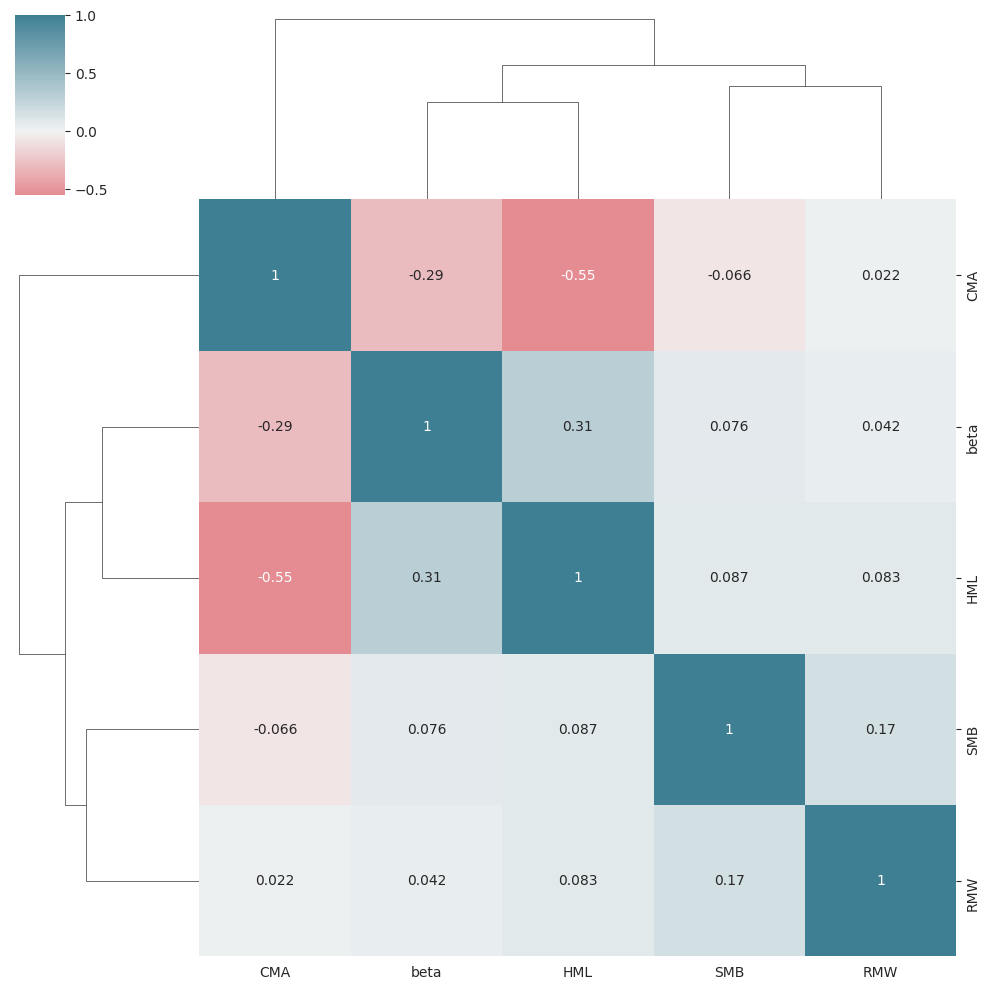

In [98]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [99]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift())
       .dropna()
       .sort_index())

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26941 entries, ('A', Timestamp('2013-01-31 00:00:00')) to ('ZION', Timestamp('2018-03-31 00:00:00'))
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   close       26941 non-null  float64
 1   sector      26941 non-null  object 
 2   rsi         26941 non-null  float64
 3   bb_high     26941 non-null  float64
 4   bb_mid      26941 non-null  float64
 5   bb_low      26941 non-null  float64
 6   bb_up       26941 non-null  float64
 7   bb_down     26941 non-null  float64
 8   atr         26941 non-null  float64
 9   natr        26941 non-null  float64
 10  macd        26941 non-null  float64
 11  return_1m   26941 non-null  float64
 12  return_3m   26941 non-null  float64
 13  return_6m   26941 non-null  float64
 14  return_12m  26941 non-null  float64
 15  beta        26941 non-null  float64
 16  SMB         26941 non-null  float64
 17  HML         26941 non-null  floa

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [101]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)    

## Date Indicators

In [102]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [103]:
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)

In [104]:
data = data.dropna()

In [105]:
data.sort_index().info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26452 entries, ('A', Timestamp('2013-01-31 00:00:00')) to ('ZION', Timestamp('2018-02-28 00:00:00'))
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   close          26452 non-null  float64
 1   sector         26452 non-null  object 
 2   rsi            26452 non-null  float64
 3   bb_high        26452 non-null  float64
 4   bb_mid         26452 non-null  float64
 5   bb_low         26452 non-null  float64
 6   bb_up          26452 non-null  float64
 7   bb_down        26452 non-null  float64
 8   atr            26452 non-null  float64
 9   natr           26452 non-null  float64
 10  macd           26452 non-null  float64
 11  return_1m      26452 non-null  float64
 12  return_3m      26452 non-null  float64
 13  return_6m      26452 non-null  float64
 14  return_12m     26452 non-null  float64
 15  beta           26452 non-null  float64
 16  SMB            2645

## Sector Breakdown

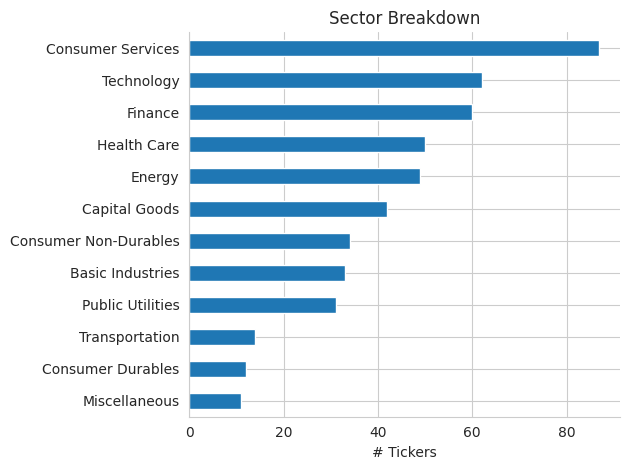

In [106]:
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

## Store data

In [107]:
with pd.HDFStore('data.h5') as store:
    store.put('us/equities/monthly', data)

## Evaluate mutual information

In [108]:
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]

In [109]:
mi = mutual_info_regression(X=X, y=data.target)

In [110]:
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

natr            0.074451
return_12m      0.048042
momentum_3_6    0.036078
return_3m       0.035403
return_6m       0.035035
month           0.033302
close           0.032674
bb_high         0.031016
bb_mid          0.029777
year            0.028880
dtype: float64

In [111]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [112]:
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

year           0.011960
month          0.008399
HML            0.007001
momentum_12    0.006743
macd           0.006152
return_1m      0.004800
return_6m      0.004700
natr           0.004001
bb_down        0.003344
return_12m     0.003309
dtype: float64

In [113]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

In [114]:
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

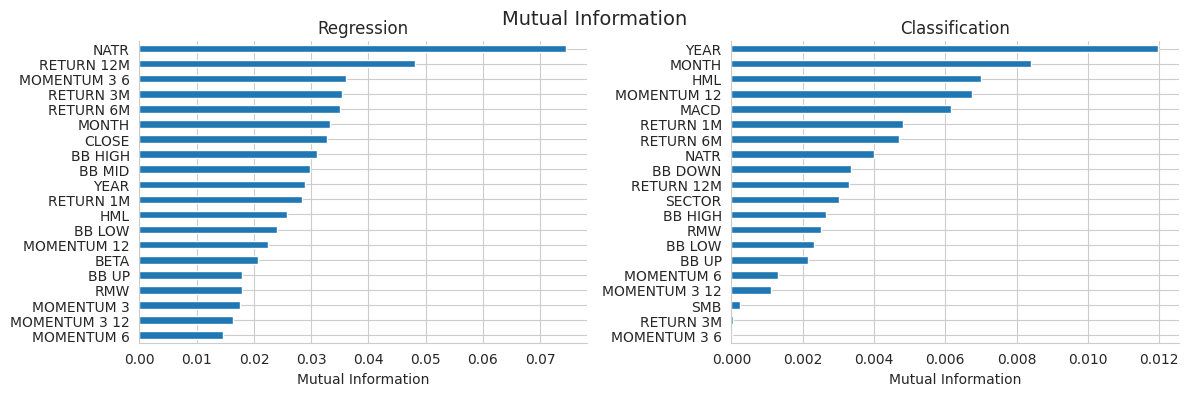

In [115]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)